# 1. Environment Setup

## Restart runtime after running the folowwing cell (1.1 Package installation)

## 1.1 Package installation

To ensure compatibility and avoid conflicts between different libraries (especially for deep learning components like `torch`, `transformers`, and `peft` used by `autogluon.timeseries`), specific versions of these packages are installed. This helps prevent unexpected errors during model training and execution.

In [ ]:
%%capture
# 1) Remove incompatible torch stack
!pip uninstall -y torch torchaudio torchvision

# 2) Install a torch version < 2.6 (so it doesn't have the new weights_only=True default)
# 2.5.x is recent enough but still "old" in terms of that behavior.
!pip install "torch==2.5.1" "torchaudio==2.5.1" "torchvision==0.20.1"

# 3) (Re)install autogluon.timeseries + Chronos extras + compatible HF stuff
# Explicitly install accelerate to a version compatible with transformers==4.38.0 to resolve TypeError in ChronosFineTuned.
!pip install "autogluon.timeseries[chronos-openvino]==1.4.0" "transformers==4.38.0" "peft==0.5.0" #"accelerate==0.27.2"



## 1.2 Import Libraries

This cell imports all the essential libraries required for data manipulation, numerical operations, plotting, and time series forecasting.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import transformers
import importlib.metadata as md

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 1.3 Verify Versions

This cell prints the versions of `torch`, `transformers`, and `autogluon.timeseries` to confirm that the correct and compatible versions (installed in the previous step) are actively being used in the runtime environment.

Excpected values :

*   Torch: 2.5.1 (or any 2.x but < 2.6)
*   Transformers: 4.38.0
*   AutoGluon.timeseries: 1.4.0

In [ ]:
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("AutoGluon.timeseries:", md.version("autogluon.timeseries"))

Torch: 2.5.1+cu124
Transformers: 4.38.0
AutoGluon.timeseries: 1.4.0


# 2. Data Loading and Initial Preprocessing

In [ ]:
df_full = pd.read_excel('Data_Set_M2_Final.xlsx') # Read Excel file into df_full
df_full["Date"] = pd.to_datetime(df_full["Date"], format='%d.%m.%Y %H:%M') # Convert to datetime format
df_full = df_full.rename(columns={'Total System Imbalance (Positiv = long / Negativ = short)': 'Imbalance'}) # Rename column

# Drop NaN values specifically from the 'Imbalance' column and assign back to df_full
df_full = df_full.dropna(subset=['Imbalance'])

test_period_length_15min = 96 # Define test period length (96 15-minute intervals = 24 hours)
df_train_original = df_full.iloc[:-test_period_length_15min].copy() # Create training set
df_test_original = df_full.iloc[-test_period_length_15min:].copy() # Create test set

print("Shape of df_full:", df_full.shape)
print("Shape of df_train_original:", df_train_original.shape)
print("Shape of df_test_original:", df_test_original.shape)

Shape of df_full: (107040, 31)
Shape of df_train_original: (106944, 31)
Shape of df_test_original: (96, 31)


# 3. Baseline Models Performance

## 3.1 Setting up Train-Test Split for Baselines

### 3.1.1 Prepare Baseline Training Data


In [ ]:
system_imbalance_ts = df_train_original[["Date","Imbalance"]].copy() # Select columns and create a new DataFrame as a copy
system_imbalance_ts.rename(columns={"Date": "datetime", "Imbalance":"target"}, inplace=True) # Rename columns
system_imbalance_ts["ID"] = "imbalance" # Add 'ID' column

# Convert to TimeSeriesDataFrame for frequency conversion a nd imputation
system_imbalance_ts = TimeSeriesDataFrame.from_data_frame(
    system_imbalance_ts,
    id_column= "ID" ,
    timestamp_column= "datetime"  ,
)

# Convert the data to hourly frequency
system_imbalance_ts = system_imbalance_ts.convert_frequency(freq="h", agg_numeric= "mean")
# Fill missing values using interpolation
system_imbalance_ts = system_imbalance_ts.fill_missing_values(method = "interpolate")
# Sort the values
system_imbalance_ts.sort_values(by="timestamp", inplace=True)

system_imbalance_ts.head() # Display the first few rows
system_imbalance_ts.tail() # Display the last few rows

target
item_id   timestamp                   
imbalance 2025-08-30 19:00:00  11.7425
          2025-08-30 20:00:00   1.1300
          2025-08-30 21:00:00  65.7125
          2025-08-30 22:00:00  58.9900
          2025-08-30 23:00:00  94.9350

### 3.1.2 Prepare Baseline Test Data

In [ ]:
system_imbalance_ts_test = df_test_original[["Date","Imbalance"]].copy() # Create a new DataFrame and ensure it's a copy
system_imbalance_ts_test.rename(columns={"Date": "datetime", "Imbalance":"target"}, inplace=True) # Rename columns
system_imbalance_ts_test["ID"] = "imbalance" # Add 'ID' column

# Convert to TimeSeriesDataFrame for frequency conversion and imputation
system_imbalance_ts_test = TimeSeriesDataFrame.from_data_frame(
    system_imbalance_ts_test,
    id_column= "ID" ,
    timestamp_column= "datetime"  ,
)

# Convert the data to hourly frequency
system_imbalance_ts_test = system_imbalance_ts_test.convert_frequency(freq="h", agg_numeric= "mean")
# Fill missing values using interpolation
system_imbalance_ts_test = system_imbalance_ts_test.fill_missing_values(method = "interpolate")
# Sort the values
system_imbalance_ts_test.sort_values(by="timestamp", inplace=True)

system_imbalance_ts_test.head() # Display the first few rows

target
item_id   timestamp                   
imbalance 2025-08-31 00:00:00  62.3500
          2025-08-31 01:00:00  49.6375
          2025-08-31 02:00:00  44.8700
          2025-08-31 03:00:00  35.8675
          2025-08-31 04:00:00   4.3600

## 3.2 Calculate Naive Baseline MAE

This step establishes a simple naive baseline model for comparison. It predicts the last known value from the training set for all periods in the test set and calculates the Mean Absolute Error (MAE).

In [ ]:
last_train_value = system_imbalance_ts["target"].iloc[-1] # Extract the last target value from the training set
actual_test_values = system_imbalance_ts_test["target"] # Extract the actual target values from the test set

# Create a naive prediction series by repeating the last training target value
naive_predictions = np.full_like(actual_test_values.values, last_train_value)

# Calculate the Mean Absolute Error (MAE)
naive_mae = mean_absolute_error(actual_test_values, naive_predictions)

print(f"Naive Baseline MAE: {naive_mae}")
print(system_imbalance_ts["target"].iloc[-1])

Naive Baseline MAE: 101.76541666666667
94.935


## 3.3 Calculate Zero Baseline MAE

This step calculates the Mean Absolute Error (MAE) for a simple baseline model that predicts a value of 0 for all future time steps in the test set.

In [ ]:
zero_predictions = np.zeros_like(actual_test_values.values) # Create an array of zeros with the same shape as actual_test_values
zero_mae = mean_absolute_error(actual_test_values, zero_predictions) # Calculate MAE for the zero baseline

print(f"Zero Baseline MAE: {zero_mae}")

Zero Baseline MAE: 112.35208333333333


## 3.4 Calculate Daily Seasonal Naive Baseline MAE (Lag-24)

This step calculates the Mean Absolute Error (MAE) for a baseline model that predicts the 'Imbalance' at a given hour to be equal to the 'Imbalance' of the same hour on the previous day.

In [ ]:
# Extract timestamps from the test set for easier iteration
test_timestamps = system_imbalance_ts_test.index.get_level_values("timestamp")

# Create a list to store the daily seasonal naive predictions
daily_seasonal_naive_predictions_values = []

# Use a pre-computed Series for faster lookup in external_features
system_imbalance_ts_target_series = system_imbalance_ts["target"]

for timestamp_test in test_timestamps:
    # Calculate the corresponding timestamp for the day before (24 hours prior)
    timestamp_lag = timestamp_test - pd.Timedelta(days=1)

    # Retrieve the target value from the training data for the lagged timestamp
    try:
        # Assuming 'imbalance' is the only item_id
        lag_value = system_imbalance_ts_target_series.loc[("imbalance", timestamp_lag)]
        daily_seasonal_naive_predictions_values.append(lag_value)
    except KeyError:
        # If a lagged value is not found in training data, e.g., for the very first test points,
        # we can use the last known training value as a fallback or a suitable imputation.
        # For simplicity here, we'll use the last training value as a naive fallback.
        daily_seasonal_naive_predictions_values.append(last_train_value)

# Create a pandas Series for the predictions with the same index as the actual test values
daily_seasonal_naive_predictions = pd.Series(
    daily_seasonal_naive_predictions_values,
    index=actual_test_values.index # Correctly use the index of the test set
)

# Calculate MAE for the daily seasonal naive baseline
daily_seasonal_naive_mae = mean_absolute_error(actual_test_values, daily_seasonal_naive_predictions)

print(f"Daily Seasonal Naive Baseline MAE (Lag 24): {daily_seasonal_naive_mae}")

Daily Seasonal Naive Baseline MAE (Lag 24): 64.44572916666665


## 3.5 Plot with all the baselines

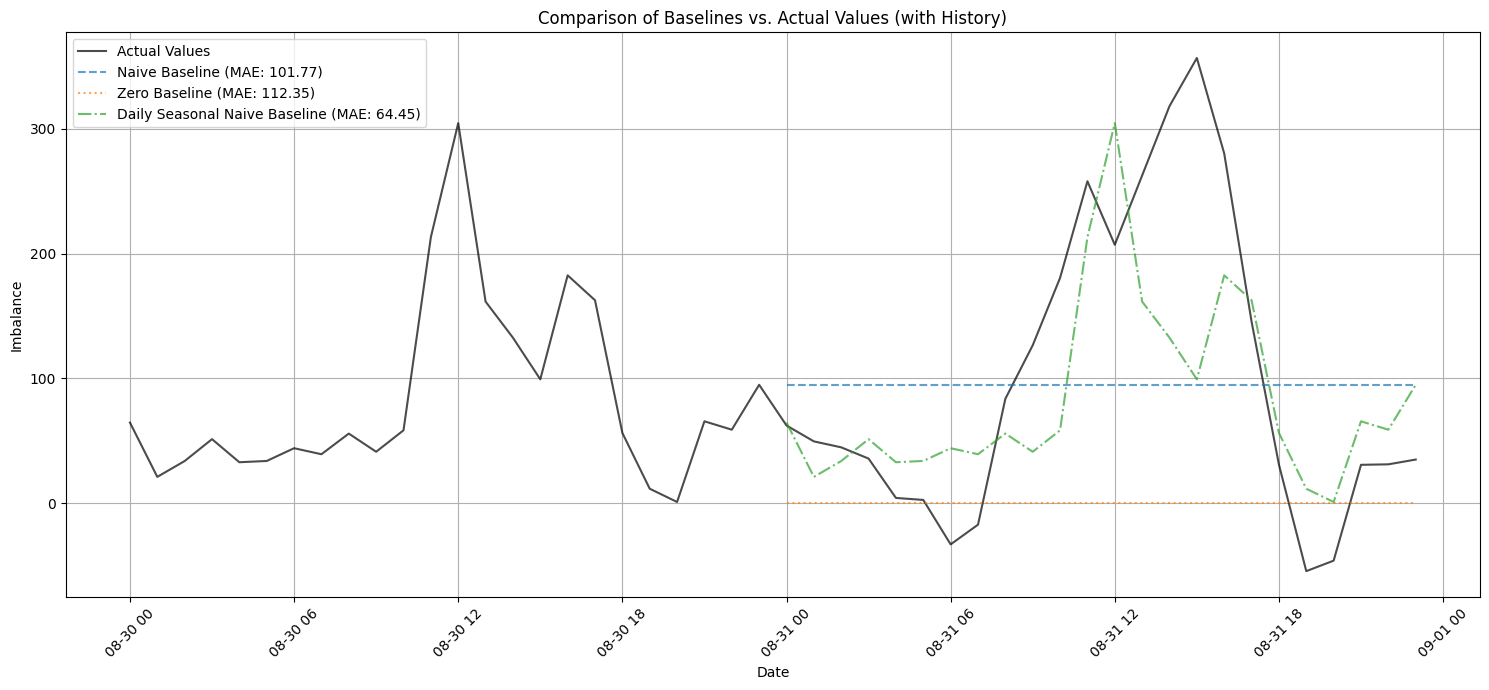

In [ ]:
plt.figure(figsize=(15, 7))

# Get the last 24 hours of external_features (August 30th)
history_actual_values = external_features.loc[("imbalance", slice("2025-08-30 00:00:00", "2025-08-30 23:00:00")), "target"]

# Combine history with test actual values
full_actual_values = pd.concat([history_actual_values, actual_test_values_covariates])

# Plot actual values
plt.plot(full_actual_values.index.get_level_values('timestamp'), full_actual_values.values, label='Actual Values', color='black', alpha=0.7)

# Plot Naive Baseline predictions
plt.plot(actual_test_values_covariates.index.get_level_values('timestamp'), naive_predictions, label=f'Naive Baseline (MAE: {naive_mae:.2f})', linestyle='--', alpha=0.7)

# Plot Zero Baseline predictions
plt.plot(actual_test_values_covariates.index.get_level_values('timestamp'), zero_predictions, label=f'Zero Baseline (MAE: {zero_mae:.2f})', linestyle=':', alpha=0.7)

# Plot Daily Seasonal Naive Baseline predictions
plt.plot(daily_seasonal_naive_predictions.index.get_level_values('timestamp'), daily_seasonal_naive_predictions.values, label=f'Daily Seasonal Naive Baseline (MAE: {daily_seasonal_naive_mae:.2f})', linestyle='-.', alpha=0.7)


plt.title('Comparison of Baselines vs. Actual Values (with History)')
plt.xlabel('Date')
plt.ylabel('Imbalance')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. AutoGluon Forecasting without Covariates

## 4.1 Train AutoGluon Predictor without Covariates
To train an AutoGluon model without covariates, I will initialize a TimeSeriesPredictor with the specified parameters and then fit it to the `system_imbalance_ts` data.

In [ ]:
predictor_no_covariates = TimeSeriesPredictor(
    prediction_length=24,
    target="target",
    eval_metric="MASE",
    path="autogluon-m4-hourly-no-covariates"
)

predictor_no_covariates.fit(
    system_imbalance_ts,
    presets="high_quality",
    time_limit=600
)

print("AutoGluon TimeSeriesPredictor (without covariates) trained successfully.")

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/autogluon-m4-hourly-no-covariates'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       10.23 GB / 12.67 GB (80.8%)
Disk Space Avail:   59.64 GB / 107.72 GB (55.4%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 26736 rows, 

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/trainer.py", line 357, in _train_and_save
    model = self._train_single(train_data, model, val_data=val_data, time_limit=time_limit)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/trainer.py", line 273, in _train_single
    model.fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 515, in fit
    self._fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/multi_window/multi_window_model.py", line 137, in _fit
    model.fit(
  File "/usr/local/lib/python3.12/dist-packages/autogluon/timeseries/models/abstract/abstract_timeseries_model.py", line 515, in fit
    self._fit(
  File "/u

┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name  ┃ Type                    ┃ Params ┃ Mode  ┃ FLOPs ┃               In sizes ┃               Out sizes ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ model │ TemporalFusionTransfor… │  121 K │ train │ 7.3 M │ [[1, 64], [1, 64], [1, │  [[[1, 24, 9]], [1, 1], │
│   │       │                         │        │       │       │    1], [1, 1], [1, 88, │                 [1, 1]] │
│   │       │                         │        │       │       │    4], [1, 88, 0], [1, │                         │
│   │       │                         │        │       │       │    64, 0], [1, 64, 0]] │                         │
└───┴───────┴─────────────────────────┴────────┴───────┴───────┴────────────────────────┴─────────────────────────┘

Trainable params: 121 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 121 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 225                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 7.3 M

	-0.4532       = Validation score (-MASE)
	108.35  s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 112.0s of the 448.1s of remaining time.


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃   ┃ Name  ┃ Type        ┃ Params ┃ Mode  ┃ FLOPs ┃                                      In sizes ┃    Out sizes ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 0 │ model │ DeepARModel │ 27.6 K │ train │ 563 K │   [[1, 1], [1, 1], [1, 768, 5], [1, 768], [1, │ [1, 100, 24] │
│   │       │             │        │       │       │                             768], [1, 24, 5]] │              │
└───┴───────┴─────────────┴────────┴───────┴───────┴───────────────────────────────────────────────┴──────────────┘

Trainable params: 27.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 27.6 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 11                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 563 K

	-0.8183       = Validation score (-MASE)
	101.39  s     = Training runtime
	0.18    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 115.5s of the 346.5s of remaining time.


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ PatchTSTModel │  322 K │ train │     0 │
└───┴───────┴───────────────┴────────┴───────┴───────┘

Trainable params: 321 K                                                                                            
Non-trainable params: 384                                                                                          
Total params: 322 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 34                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

	-0.4987       = Validation score (-MASE)
	66.69   s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model TiDE. Training for up to 139.9s of the 279.7s of remaining time.


┏━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type      ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ TiDEModel │  964 K │ train │     0 │
└───┴───────┴───────────┴────────┴───────┴───────┘

Trainable params: 964 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 964 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

	-0.5238       = Validation score (-MASE)
	126.58  s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosZeroShot[bolt_base]': 0.06, 'TemporalFusionTransformer': 0.94}
	-0.4529       = Validation score (-MASE)
	1.75    s     = Training runtime
	7.08    s     = Validation (prediction) runtime
Training complete. Models trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'ChronosZeroShot[bolt_base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST', 'TiDE', 'WeightedEnsemble']
Total runtime: 448.78 s
Best model: WeightedEnsemble
Best model score: -0.4529


AutoGluon TimeSeriesPredictor (without covariates) trained successfully.


## 4.2 Predictions and MAE for AutoGluon Model without Covariates


The previous step successfully trained the `predictor_no_covariates` model. The next logical step is to generate predictions using this newly trained model on the test data and then evaluate its performance by calculating the Mean Absolute Error (MAE).



In [ ]:
# Build the correct input for prediction:
#    AutoGluon always forecasts beyond the last timestamp* in the input.
#    Here we want to forecast the next 24h after the end of system_imbalance_ts.
prediction_input = system_imbalance_ts.copy()

# Generate next-24-hour forecast
predictions_no_covariates = predictor_no_covariates.predict(prediction_input)

# Extract the mean forecast for the only ID ("imbalance")
predicted_values_no_covariates = predictions_no_covariates.loc["imbalance"]["mean"]


# Extract the true 24-hour values from the hourly test set
y_true = system_imbalance_ts_test["target"]


# Compute MAE
autogluon_mae_no_covariates = mean_absolute_error(y_true, predicted_values_no_covariates)

print(f"AutoGluon Model MAE (without covariates): {autogluon_mae_no_covariates}")


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


AutoGluon Model MAE (without covariates): 94.43708569844564


# 5. AutoGluon Forecasting with Time-Only Covariates

## 5.1 Feature Engineering for Time-Only Covariates (Training Data)

Enhance the training data (`df_train_original`) by engineering cyclical temporal features ('Weekday', 'Hour_of_day', 'Month_of_year') and including 'Season' as a numerical covariate, while excluding 'GST_Average' and 'Temp_Average'. Missing values will be imputed using interpolation.


In [ ]:
external_features_Time_Only = df_train_original[['Date', 'Imbalance']].copy() # Create external_features_Time_Only DataFrame with only 'Date' and 'Imbalance'
external_features_Time_Only.rename(columns={"Date": "datetime", "Imbalance":"target"}, inplace=True) # Rename columns
external_features_Time_Only["item_id"] = "imbalance" # Add 'item_id' column

# Convert to TimeSeriesDataFrame
external_features_Time_Only = TimeSeriesDataFrame.from_data_frame(
    external_features_Time_Only,
    id_column= "item_id" ,
    timestamp_column= "datetime"  ,
)

# Convert the data to hourly frequency
external_features_Time_Only = external_features_Time_Only.convert_frequency(freq="h", agg_numeric= "mean")
# Fill missing values using interpolation
external_features_Time_Only = external_features_Time_Only.fill_missing_values(method = "interpolate")

# Extract timestamps
timestamps = external_features_Time_Only.index.get_level_values("timestamp")

# Add 'Season' as a numerical covariate
external_features_Time_Only["Season"] = ((timestamps.month%12 + 3)//3)

# Create cyclical sine and cosine features for 'Weekday', 'Hour_of_day', and 'Month_of_year'
external_features_Time_Only["Weekday_sin"] = np.sin(2 * np.pi * timestamps.weekday / 7)
external_features_Time_Only["Weekday_cos"] = np.cos(2 * np.pi * timestamps.weekday / 7)
external_features_Time_Only["Hour_of_day_sin"] = np.sin(2 * np.pi * timestamps.hour / 24)
external_features_Time_Only["Hour_of_day_cos"] = np.cos(2 * np.pi * timestamps.hour / 24)
external_features_Time_Only["Month_of_year_sin"] = np.sin(2 * np.pi * (timestamps.month - 1) / 12)
external_features_Time_Only["Month_of_year_cos"] = np.cos(2 * np.pi * (timestamps.month - 1) / 12)

external_features_Time_Only.head() # Display the first few rows

target  Season  Weekday_sin  Weekday_cos  \
item_id   timestamp                                                        
imbalance 2022-08-13 00:00:00 -42.3050       3    -0.974928    -0.222521   
          2022-08-13 01:00:00 -11.0650       3    -0.974928    -0.222521   
          2022-08-13 02:00:00   2.1700       3    -0.974928    -0.222521   
          2022-08-13 03:00:00  16.1575       3    -0.974928    -0.222521   
          2022-08-13 04:00:00  -1.7050       3    -0.974928    -0.222521   

                               Hour_of_day_sin  Hour_of_day_cos  \
item_id   timestamp                                               
imbalance 2022-08-13 00:00:00         0.000000         1.000000   
          2022-08-13 01:00:00         0.258819         0.965926   
          2022-08-13 02:00:00         0.500000         0.866025   
          2022-08-13 03:00:00         0.707107         0.707107   
          2022-08-13 04:00:00         0.866025         0.500000   

                               Month_of_year_sin  Month_of_year_cos  
item_id   timestamp                                                  
imbalance 2022-08-13 00:00:00               -0.5          -0.866025  
          2022-08-13 01:00:00               -0.5          -0.866025  
          2022-08-13 02:00:00               -0.5          -0.866025  
          2022-08-13 03:00:00               -0.5          -0.866025  
          2022-08-13 04:00:00               -0.5          -0.866025

## 5.2 Feature Engineering for Time-Only Covariates (Test Data)


In [ ]:
external_features_test_Time_Only = df_test_original[['Date', 'Imbalance']].copy() # Create external_features_test_Time_Only DataFrame
external_features_test_Time_Only.rename(columns={"Date": "datetime", "Imbalance":"target"}, inplace=True) # Rename columns
external_features_test_Time_Only["item_id"] = "imbalance" # Add 'item_id' column

# Convert to TimeSeriesDataFrame
external_features_test_Time_Only = TimeSeriesDataFrame.from_data_frame(
    external_features_test_Time_Only,
    id_column= "item_id" ,
    timestamp_column= "datetime"  ,
)

# Convert the data to hourly frequency
external_features_test_Time_Only = external_features_test_Time_Only.convert_frequency(freq="h", agg_numeric= "mean")
# Fill missing values using interpolation
external_features_test_Time_Only = external_features_test_Time_Only.fill_missing_values(method = "interpolate")

# Extract timestamps
timestamps_test_Time_Only = external_features_test_Time_Only.index.get_level_values("timestamp")

# Add 'Season' as a numerical covariate
external_features_test_Time_Only["Season"] = ((timestamps_test_Time_Only.month%12 + 3)//3)

# Create cyclical temporal features using sine and cosine transformations
external_features_test_Time_Only["Weekday_sin"] = np.sin(2 * np.pi * timestamps_test_Time_Only.weekday / 7)
external_features_test_Time_Only["Weekday_cos"] = np.cos(2 * np.pi * timestamps_test_Time_Only.weekday / 7)
external_features_test_Time_Only["Hour_of_day_sin"] = np.sin(2 * np.pi * timestamps_test_Time_Only.hour / 24)
external_features_test_Time_Only["Hour_of_day_cos"] = np.cos(2 * np.pi * timestamps_test_Time_Only.hour / 24)
external_features_test_Time_Only["Month_of_year_sin"] = np.sin(2 * np.pi * (timestamps_test_Time_Only.month - 1) / 12)
external_features_test_Time_Only["Month_of_year_cos"] = np.cos(2 * np.pi * (timestamps_test_Time_Only.month - 1) / 12)

# Create known_covariates_Time_Only by dropping the 'target' column
known_covariates_Time_Only = external_features_test_Time_Only.drop(columns=["target"])

external_features_test_Time_Only.head() # Display the first few rows of external_features_test_Time_Only
known_covariates_Time_Only.tail() # Display the last few rows of known_covariates_Time_Only

Season  Weekday_sin  Weekday_cos  \
item_id   timestamp                                               
imbalance 2025-08-31 19:00:00       3    -0.781831      0.62349   
          2025-08-31 20:00:00       3    -0.781831      0.62349   
          2025-08-31 21:00:00       3    -0.781831      0.62349   
          2025-08-31 22:00:00       3    -0.781831      0.62349   
          2025-08-31 23:00:00       3    -0.781831      0.62349   

                               Hour_of_day_sin  Hour_of_day_cos  \
item_id   timestamp                                               
imbalance 2025-08-31 19:00:00        -0.965926         0.258819   
          2025-08-31 20:00:00        -0.866025         0.500000   
          2025-08-31 21:00:00        -0.707107         0.707107   
          2025-08-31 22:00:00        -0.500000         0.866025   
          2025-08-31 23:00:00        -0.258819         0.965926   

                               Month_of_year_sin  Month_of_year_cos  
item_id   timestamp                                                  
imbalance 2025-08-31 19:00:00               -0.5          -0.866025  
          2025-08-31 20:00:00               -0.5          -0.866025  
          2025-08-31 21:00:00               -0.5          -0.866025  
          2025-08-31 22:00:00               -0.5          -0.866025  
          2025-08-31 23:00:00               -0.5          -0.866025

## 5.3 Train AutoGluon Predictor with Time-Only Covariates

With the training data prepared with engineered cyclical temporal features and 'Season' as covariates, the next step is to train a new AutoGluon TimeSeriesPredictor using this data.


In [ ]:
known_covariates_list_Time_Only = [
    "Season",
    "Weekday_sin", "Weekday_cos",
    "Hour_of_day_sin", "Hour_of_day_cos",
    "Month_of_year_sin", "Month_of_year_cos"
]

predictor_Time_Only = TimeSeriesPredictor(
    prediction_length=24,
    target="target",
    eval_metric="MASE",
    path="autogluon-m4-hourly-Time_Only-covariates-cyclical", # Unique path for this model
    known_covariates_names=known_covariates_list_Time_Only,
    )

predictor_Time_Only.fit(
    external_features_Time_Only,
    presets="high_quality",
    time_limit=600
)
print("AutoGluon TimeSeriesPredictor (with Time_Only covariates) trained successfully.")

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/autogluon-m4-hourly-Time_Only-covariates-cyclical'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       10.00 GB / 12.67 GB (78.9%)
Disk Space Avail:   59.58 GB / 107.72 GB (55.3%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': ['Season',
                            'Weekday_sin',
                            'Weekday_cos',
                            'Hour_of_day_sin',
                            'Hour_of_day_cos',
                            'Month_of_year_sin',
                            'Month_of_year_cos'],
 'num_val_windows': 1,
 'prediction_length': 24,


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name  ┃ Type                    ┃ Params ┃ Mode  ┃ FLOPs ┃               In sizes ┃               Out sizes ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ model │ TemporalFusionTransfor… │  132 K │ train │ 8.3 M │ [[1, 64], [1, 64], [1, │  [[[1, 24, 9]], [1, 1], │
│   │       │                         │        │       │       │    1], [1, 1], [1, 88, │                 [1, 1]] │
│   │       │                         │        │       │       │   11], [1, 88, 0], [1, │                         │
│   │       │                         │        │       │       │    64, 0], [1, 64, 0]] │                         │
└───┴───────┴─────────────────────────┴────────┴───────┴───────┴────────────────────────┴─────────────────────────┘

Trainable params: 132 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 132 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 244                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 8.3 M

	-0.3996       = Validation score (-MASE)
	105.99  s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 119.6s of the 478.4s of remaining time.


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃   ┃ Name  ┃ Type        ┃ Params ┃ Mode  ┃ FLOPs ┃                                      In sizes ┃    Out sizes ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 0 │ model │ DeepARModel │ 28.8 K │ train │ 563 K │  [[1, 1], [1, 1], [1, 768, 12], [1, 768], [1, │ [1, 100, 24] │
│   │       │             │        │       │       │                            768], [1, 24, 12]] │              │
└───┴───────┴─────────────┴────────┴───────┴───────┴───────────────────────────────────────────────┴──────────────┘

Trainable params: 28.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 28.8 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 11                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 563 K

	-0.7671       = Validation score (-MASE)
	108.14  s     = Training runtime
	0.21    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 123.3s of the 370.0s of remaining time.


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ PatchTSTModel │  325 K │ train │     0 │
└───┴───────┴───────────────┴────────┴───────┴───────┘

Trainable params: 325 K                                                                                            
Non-trainable params: 384                                                                                          
Total params: 325 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 34                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

	-0.4109       = Validation score (-MASE)
	94.04   s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model TiDE. Training for up to 138.0s of the 275.9s of remaining time.


┏━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type      ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ TiDEModel │  964 K │ train │     0 │
└───┴───────┴───────────┴────────┴───────┴───────┘

Trainable params: 964 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 964 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

	-0.5235       = Validation score (-MASE)
	124.92  s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'TemporalFusionTransformer': 1.0}
	-0.3996       = Validation score (-MASE)
	0.80    s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training complete. Models trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'ChronosZeroShot[bolt_base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST', 'TiDE', 'WeightedEnsemble']
Total runtime: 449.91 s
Best model: TemporalFusionTransformer
Best model score: -0.3996


AutoGluon TimeSeriesPredictor (with Time_Only covariates) trained successfully.


## 5.4 Predictions and MAE for Time-Only Covariates AutoGluon Model
Generate predictions using this newly trained model on the prepared test data (`known_covariates_Time_Only`) and evaluate its performance.



In [ ]:
predictions_Time_Only = predictor_Time_Only.predict(external_features_Time_Only, known_covariates=known_covariates_Time_Only)

# Extract the 'mean' predictions for MAE calculation
predicted_values_Time_Only = predictions_Time_Only['mean']

# Extract the actual target values from the test set (already prepared as actual_test_values_for_no_covariates)
actual_test_values_Time_Only = external_features_test_Time_Only['target']

# Calculate MAE for the AutoGluon model with Time_Only covariates
autogluon_mae_Time_Only = mean_absolute_error(actual_test_values_Time_Only, predicted_values_Time_Only)

print(f"AutoGluon Model MAE (with Time_Only covariates): {autogluon_mae_Time_Only}")

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


AutoGluon Model MAE (with Time_Only covariates): 82.33060019175213


# 6. AutoGluon Forecasting with All Covariates

## 6.1 Feature Engineering for All Covariates (Training Data)

This section enhances the training data by adding external features (`GST_Average`, `Temp_Average`) and engineering cyclical temporal features (sine/cosine transformations for 'Weekday', 'Hour_of_day', 'Month_of_year') to better capture periodic patterns. 'Season' is included as a numeric covariate. Missing values are imputed using interpolation.

In [ ]:
external_features = df_train_original[['Date', 'Imbalance', 'GST_Average', 'Temp_Average']].copy() # Create external_features DataFrame
external_features.rename(columns={"Date": "datetime", "Imbalance":"target"}, inplace=True) # Rename columns
external_features["item_id"] = "imbalance" # Add 'item_id' column

# Convert to TimeSeriesDataFrame
external_features = TimeSeriesDataFrame.from_data_frame(
    external_features,
    id_column= "item_id" ,
    timestamp_column= "datetime"  ,
)

# Convert the data to hourly frequency
external_features = external_features.convert_frequency(freq="h", agg_numeric= "mean")
# Fill missing values using interpolation
external_features = external_features.fill_missing_values(method = "interpolate")

# Extract timestamps
timestamps_train = external_features.index.get_level_values("timestamp")

# Add 'Season' as a numerical covariate
external_features["Season"] = ((timestamps_train.month%12 + 3)//3)

# Create cyclical sine and cosine features for 'Weekday', 'Hour_of_day', and 'Month_of_year'
external_features["Weekday_sin"] = np.sin(2 * np.pi * timestamps_train.weekday / 7)
external_features["Weekday_cos"] = np.cos(2 * np.pi * timestamps_train.weekday / 7)
external_features["Hour_of_day_sin"] = np.sin(2 * np.pi * timestamps_train.hour / 24)
external_features["Hour_of_day_cos"] = np.cos(2 * np.pi * timestamps_train.hour / 24)
external_features["Month_of_year_sin"] = np.sin(2 * np.pi * (timestamps_train.month - 1) / 12)
external_features["Month_of_year_cos"] = np.cos(2 * np.pi * (timestamps_train.month - 1) / 12)

external_features.head() # Display the first few rows

target  GST_Average  Temp_Average  Season  \
item_id   timestamp                                                         
imbalance 2022-08-13 00:00:00 -42.3050          0.0         -2.15       3   
          2022-08-13 01:00:00 -11.0650          0.0         -2.45       3   
          2022-08-13 02:00:00   2.1700          0.0         -1.72       3   
          2022-08-13 03:00:00  16.1575          0.0         -1.53       3   
          2022-08-13 04:00:00  -1.7050          0.0         -1.32       3   

                               Weekday_sin  Weekday_cos  Hour_of_day_sin  \
item_id   timestamp                                                        
imbalance 2022-08-13 00:00:00    -0.974928    -0.222521         0.000000   
          2022-08-13 01:00:00    -0.974928    -0.222521         0.258819   
          2022-08-13 02:00:00    -0.974928    -0.222521         0.500000   
          2022-08-13 03:00:00    -0.974928    -0.222521         0.707107   
          2022-08-13 04:00:00    -0.974928    -0.222521         0.866025   

                               Hour_of_day_cos  Month_of_year_sin  \
item_id   timestamp                                                 
imbalance 2022-08-13 00:00:00         1.000000               -0.5   
          2022-08-13 01:00:00         0.965926               -0.5   
          2022-08-13 02:00:00         0.866025               -0.5   
          2022-08-13 03:00:00         0.707107               -0.5   
          2022-08-13 04:00:00         0.500000               -0.5   

                               Month_of_year_cos  
item_id   timestamp                               
imbalance 2022-08-13 00:00:00          -0.866025  
          2022-08-13 01:00:00          -0.866025  
          2022-08-13 02:00:00          -0.866025  
          2022-08-13 03:00:00          -0.866025  
          2022-08-13 04:00:00          -0.866025

## 6.2 Feature Engineering for All Covariates (Test Data)

This section prepares the test data with the same external and cyclical temporal features as the training data. It also creates the `known_covariates` DataFrame, which will be provided to the AutoGluon predictor for forecasting. This ensures that the test data aligns with the model's expectations during prediction.

In [ ]:
external_features_test = df_test_original[['Date', 'Imbalance', 'GST_Average', 'Temp_Average']].copy() # Create external_features_test DataFrame
external_features_test.rename(columns={"Date": "datetime", "Imbalance":"target"}, inplace=True) # Rename columns
external_features_test["item_id"] = "imbalance" # Add 'item_id' column

# Convert to TimeSeriesDataFrame
external_features_test = TimeSeriesDataFrame.from_data_frame(
    external_features_test,
    id_column= "item_id" ,
    timestamp_column= "datetime"  ,
)

# Convert the data to hourly frequency
external_features_test = external_features_test.convert_frequency(freq="h", agg_numeric= "mean")
# Fill missing values using interpolation
external_features_test = external_features_test.fill_missing_values(method = "interpolate")

# Extract timestamps
timestamps_test = external_features_test.index.get_level_values("timestamp")

# Add 'Season' as a numerical covariate
external_features_test["Season"] = ((timestamps_test.month%12 + 3)//3)

# Create cyclical temporal features using sine and cosine transformations
external_features_test["Weekday_sin"] = np.sin(2 * np.pi * timestamps_test.weekday / 7)
external_features_test["Weekday_cos"] = np.cos(2 * np.pi * timestamps_test.weekday / 7)
external_features_test["Hour_of_day_sin"] = np.sin(2 * np.pi * timestamps_test.hour / 24)
external_features_test["Hour_of_day_cos"] = np.cos(2 * np.pi * timestamps_test.hour / 24)
external_features_test["Month_of_year_sin"] = np.sin(2 * np.pi * (timestamps_test.month - 1) / 12)
external_features_test["Month_of_year_cos"] = np.cos(2 * np.pi * (timestamps_test.month - 1) / 12)

# Create known_covariates by dropping the 'target' and past covariates
# The known_covariates DataFrame should contain only the features that are known at prediction time.
# GST_Average and Temp_Average will be inferred as past_covariates by AutoGluon, so we drop them from known_covariates.
known_covariates = external_features_test.drop(columns=["target", "GST_Average", "Temp_Average"])

external_features_test.head() # Display the first few rows of external_features_test
known_covariates.tail() # Display the last few rows of known_covariates

Season  Weekday_sin  Weekday_cos  \
item_id   timestamp                                               
imbalance 2025-08-31 19:00:00       3    -0.781831      0.62349   
          2025-08-31 20:00:00       3    -0.781831      0.62349   
          2025-08-31 21:00:00       3    -0.781831      0.62349   
          2025-08-31 22:00:00       3    -0.781831      0.62349   
          2025-08-31 23:00:00       3    -0.781831      0.62349   

                               Hour_of_day_sin  Hour_of_day_cos  \
item_id   timestamp                                               
imbalance 2025-08-31 19:00:00        -0.965926         0.258819   
          2025-08-31 20:00:00        -0.866025         0.500000   
          2025-08-31 21:00:00        -0.707107         0.707107   
          2025-08-31 22:00:00        -0.500000         0.866025   
          2025-08-31 23:00:00        -0.258819         0.965926   

                               Month_of_year_sin  Month_of_year_cos  
item_id   timestamp                                                  
imbalance 2025-08-31 19:00:00               -0.5          -0.866025  
          2025-08-31 20:00:00               -0.5          -0.866025  
          2025-08-31 21:00:00               -0.5          -0.866025  
          2025-08-31 22:00:00               -0.5          -0.866025  
          2025-08-31 23:00:00               -0.5          -0.866025

## 6.3 Train AutoGluon Predictor with All Covariates

This step initializes and trains the `TimeSeriesPredictor` with the enhanced training data, leveraging the newly engineered cyclical temporal features as `known_covariates`. `high_quality` presets are used for comprehensive model exploration.

In [ ]:
known_covariates_list = [
    "Season", # Include Season as a known covariate
    "Weekday_sin", "Weekday_cos",
    "Hour_of_day_sin", "Hour_of_day_cos",
    "Month_of_year_sin", "Month_of_year_cos"
]

predictor_covariates = TimeSeriesPredictor(
    prediction_length=24,
    target="target",
    eval_metric="MASE",
    path="autogluon-m4-hourly-covariates-cyclical", # New path to avoid overwriting previous models
    known_covariates_names=known_covariates_list,
    )

predictor_covariates.fit(
    external_features,
    presets="high_quality",
    time_limit=600
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/autogluon-m4-hourly-covariates-cyclical'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       9.99 GB / 12.67 GB (78.9%)
Disk Space Avail:   59.57 GB / 107.72 GB (55.3%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': ['Season',
                            'Weekday_sin',
                            'Weekday_cos',
                            'Hour_of_day_sin',
                            'Hour_of_day_cos',
                            'Month_of_year_sin',
                            'Month_of_year_cos'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_

┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name  ┃ Type                    ┃ Params ┃ Mode  ┃ FLOPs ┃               In sizes ┃               Out sizes ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ model │ TemporalFusionTransfor… │  138 K │ train │ 9.0 M │ [[1, 64], [1, 64], [1, │  [[[1, 24, 9]], [1, 1], │
│   │       │                         │        │       │       │    1], [1, 1], [1, 88, │                 [1, 1]] │
│   │       │                         │        │       │       │   11], [1, 88, 0], [1, │                         │
│   │       │                         │        │       │       │    64, 2], [1, 64, 0]] │                         │
└───┴───────┴─────────────────────────┴────────┴───────┴───────┴────────────────────────┴─────────────────────────┘

Trainable params: 138 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 138 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 256                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 9.0 M

	-0.4857       = Validation score (-MASE)
	106.03  s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 119.8s of the 479.0s of remaining time.


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃   ┃ Name  ┃ Type        ┃ Params ┃ Mode  ┃ FLOPs ┃                                      In sizes ┃    Out sizes ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 0 │ model │ DeepARModel │ 28.8 K │ train │ 563 K │  [[1, 1], [1, 1], [1, 768, 12], [1, 768], [1, │ [1, 100, 24] │
│   │       │             │        │       │       │                            768], [1, 24, 12]] │              │
└───┴───────┴─────────────┴────────┴───────┴───────┴───────────────────────────────────────────────┴──────────────┘

Trainable params: 28.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 28.8 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 11                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 563 K

	-0.7145       = Validation score (-MASE)
	108.30  s     = Training runtime
	0.19    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 123.5s of the 370.5s of remaining time.


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ PatchTSTModel │  325 K │ train │     0 │
└───┴───────┴───────────────┴────────┴───────┴───────┘

Trainable params: 325 K                                                                                            
Non-trainable params: 384                                                                                          
Total params: 325 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 34                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

	-0.4109       = Validation score (-MASE)
	90.14   s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model TiDE. Training for up to 140.2s of the 280.3s of remaining time.


┏━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type      ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ TiDEModel │  964 K │ train │     0 │
└───┴───────┴───────────┴────────┴───────┴───────┘

Trainable params: 964 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 964 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 65                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

	-0.5235       = Validation score (-MASE)
	126.71  s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'PatchTST': 1.0}
	-0.4109       = Validation score (-MASE)
	0.61    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training complete. Models trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'ChronosZeroShot[bolt_base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST', 'TiDE', 'WeightedEnsemble']
Total runtime: 447.09 s
Best model: PatchTST
Best model score: -0.4109


## 6.4 Predictions and MAE for AutoGluon Model with All Covariates

In [ ]:
predictions_covariates = predictor_covariates.predict(external_features, known_covariates=known_covariates)

# Extract the 'mean' predictions for MAE calculation
predicted_values_covariates = predictions_covariates['mean']

# Extract the actual target values from the test set
actual_test_values_covariates = external_features_test['target']

# Calculate MAE for the AutoGluon model with covariates
autogluon_mae_covariates = mean_absolute_error(actual_test_values_covariates, predicted_values_covariates)

print(f"AutoGluon Model MAE (with covariates): {autogluon_mae_covariates}")


Model not specified in predict, will default to the model with the best validation score: PatchTST


AutoGluon Model MAE (with covariates): 82.77384162902833


# 7. Comparative Analysis and Visualization

## 7.1 Compare All Baselines and AutoGluon Model Performance

This step compares the performance of the AutoGluon models with covariates against the naive baseline, the zero baseline, and the new daily seasonal naive baseline using MAE.

In [ ]:
print(f"Zero Baseline MAE: {zero_mae}")
print(f"Naive Baseline MAE: {naive_mae}")
print(f"Daily Seasonal Naive Baseline MAE (Lag 24): {daily_seasonal_naive_mae}")
print(f"AutoGluon Model MAE (without covariates): {autogluon_mae_no_covariates}")
print(f"AutoGluon Model MAE (with Time_Only covariates): {autogluon_mae_Time_Only}")
print(f"AutoGluon Model MAE (with covariates): {autogluon_mae_covariates}")


Zero Baseline MAE: 112.35208333333333
Naive Baseline MAE: 101.76541666666667
Daily Seasonal Naive Baseline MAE (Lag 24): 64.44572916666665
AutoGluon Model MAE (without covariates): 94.43708569844564
AutoGluon Model MAE (with Time_Only covariates): 82.33060019175213
AutoGluon Model MAE (with covariates): 82.77384162902833


## 7.2 Visualise Results

This is a visualization of the AutoGluon predictions against the actual values from the test set, including prediction intervals.

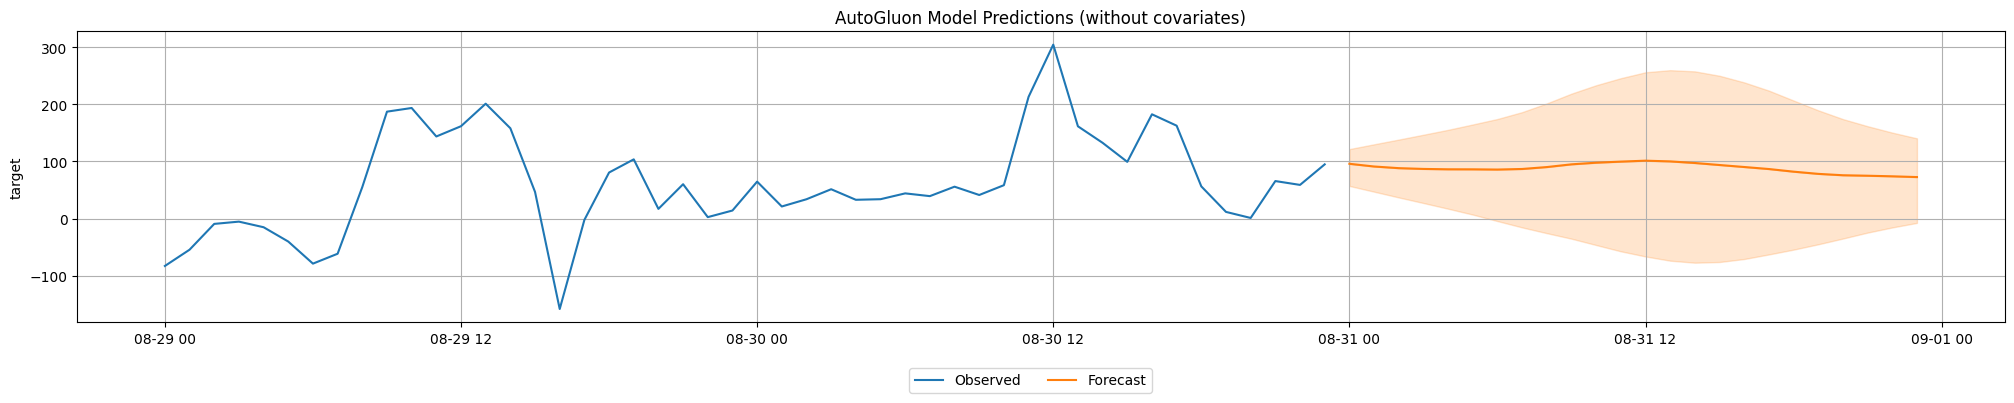

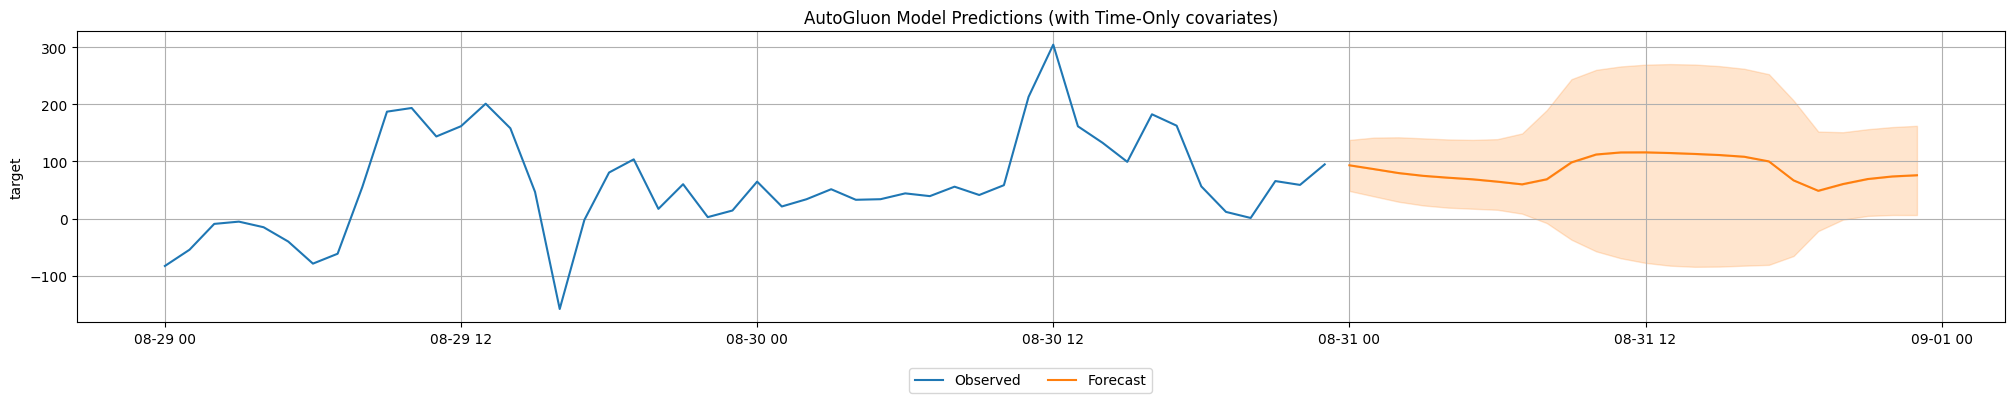

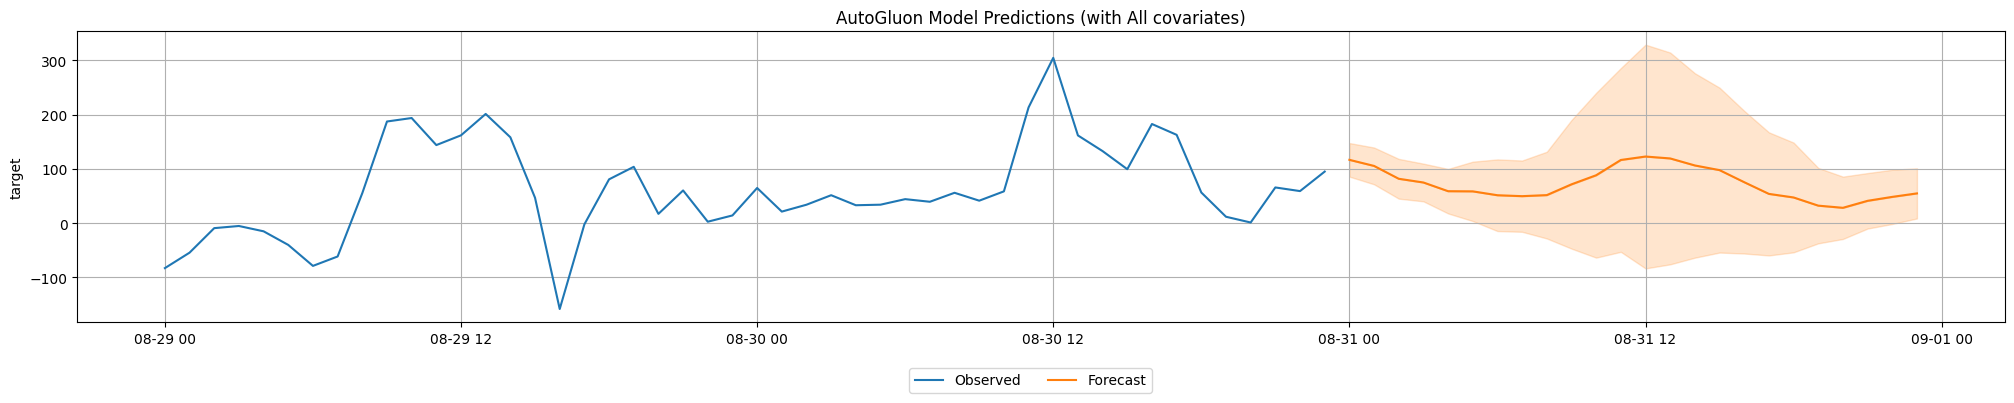

In [ ]:
predictor_no_covariates.plot(system_imbalance_ts,
                         predictions_no_covariates,
                         quantile_levels=[0.1, 0.9],
                         max_history_length=48)
plt.title('AutoGluon Model Predictions (without covariates)')
plt.show()

predictor_Time_Only.plot(external_features_Time_Only,
                         predictions_Time_Only,
                         quantile_levels=[0.1, 0.9],
                         max_history_length=48)
plt.title('AutoGluon Model Predictions (with Time-Only covariates)')
plt.show()

predictor_covariates.plot(external_features,
                         predictions_covariates,
                         quantile_levels=[0.1, 0.9],
                         max_history_length=48)
plt.title('AutoGluon Model Predictions (with All covariates)')
plt.show()

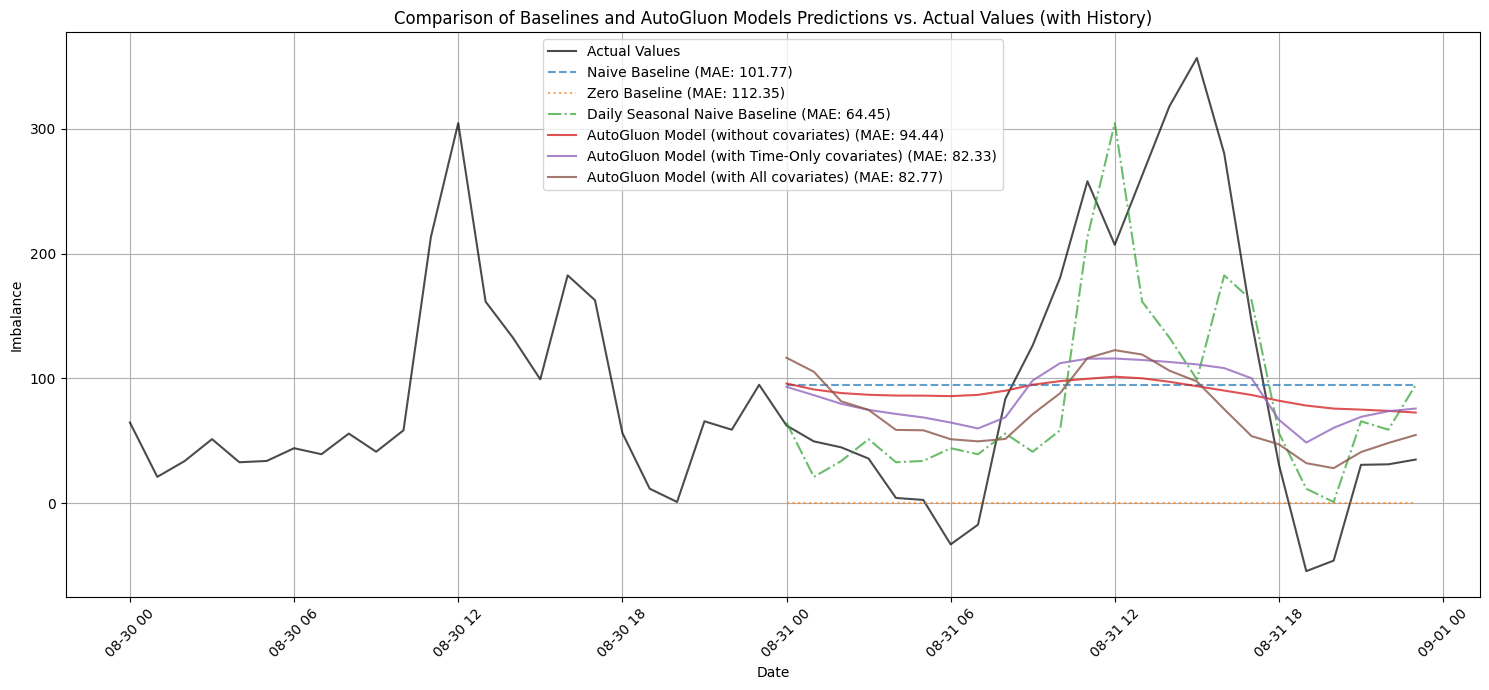

In [ ]:
plt.figure(figsize=(15, 7))

# Get the last 24 hours of external_features (August 30th)
history_actual_values = external_features.loc[("imbalance", slice("2025-08-30 00:00:00", "2025-08-30 23:00:00")), "target"]

# Combine history with test actual values
full_actual_values = pd.concat([history_actual_values, actual_test_values_covariates])

# Plot actual values
plt.plot(full_actual_values.index.get_level_values('timestamp'), full_actual_values.values, label='Actual Values', color='black', alpha=0.7)

# Plot Naive Baseline predictions
plt.plot(actual_test_values_covariates.index.get_level_values('timestamp'), naive_predictions, label=f'Naive Baseline (MAE: {naive_mae:.2f})', linestyle='--', alpha=0.7)

# Plot Zero Baseline predictions
plt.plot(actual_test_values_covariates.index.get_level_values('timestamp'), zero_predictions, label=f'Zero Baseline (MAE: {zero_mae:.2f})', linestyle=':', alpha=0.7)

# Plot Daily Seasonal Naive Baseline predictions
plt.plot(daily_seasonal_naive_predictions.index.get_level_values('timestamp'), daily_seasonal_naive_predictions.values, label=f'Daily Seasonal Naive Baseline (MAE: {daily_seasonal_naive_mae:.2f})', linestyle='-.', alpha=0.7)

# Plot AutoGluon Model without Covariates predictions
plt.plot(predicted_values_no_covariates.index.get_level_values('timestamp'), predicted_values_no_covariates.values, label=f'AutoGluon Model (without covariates) (MAE: {autogluon_mae_no_covariates:.2f})', alpha=0.8)

# Plot AutoGluon Model with Time-Only Covariates predictions
plt.plot(predicted_values_Time_Only.index.get_level_values('timestamp'), predicted_values_Time_Only.values, label=f'AutoGluon Model (with Time-Only covariates) (MAE: {autogluon_mae_Time_Only:.2f})', alpha=0.8)

# Plot AutoGluon Model with All Covariates predictions
plt.plot(predicted_values_covariates.index.get_level_values('timestamp'), predicted_values_covariates.values, label=f'AutoGluon Model (with All covariates) (MAE: {autogluon_mae_covariates:.2f})', alpha=0.8)


plt.title('Comparison of Baselines and AutoGluon Models Predictions vs. Actual Values (with History)')
plt.xlabel('Date')
plt.ylabel('Imbalance')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8. Conclusion and Next Steps

## 8.1 Summary:

### Q&A
*   The AutoGluon model, trained exclusively with Time-Only covariates (cyclical temporal features and 'Season'), achieved a Mean Absolute Error (MAE) of 82.33.
*   This model performed better than the Naive Baseline (MAE: 101.77) and the Zero Baseline (MAE: 112.35).
*   However, it performed worse than the Daily Seasonal Naive Baseline (MAE: 64.45).
*   Compared to the AutoGluon model that included 'Temp_Average' and 'GST_Average' (referred to as "AutoGluon Model MAE (with covariates)", MAE: 82.77), the MAE for the model with only Time-Only covariates was slightly better at 82.33. This suggests that while Time-Only covariates are beneficial, the additional 'Temp_Average' and 'GST_Average' covariates did not significantly improve performance in this context.
*   Time-only features were the most useful covariates. Weather forecast errors (GST_Average, Temp_Average) did not improve the model, possibly because the strong daily seasonality dominates the signal.

### Data Analysis Key Findings
*   The AutoGluon model trained with only Time-Only covariates (cyclical features for Weekday, Hour_of_day, Month_of_year, and 'Season') achieved a Mean Absolute Error (MAE) of 82.33.
*   This model outperformed the Naive Baseline (MAE: 101.77) and the Zero Baseline (MAE: 112.35).
*   The Daily Seasonal Naive Baseline (Lag 24) exhibited the best performance among all models/baselines, with an MAE of 64.45, indicating strong daily seasonality in the data.
*   The AutoGluon model without any external covariates achieved an MAE of 94.44. The AutoGluon model with Time-Only covariates achieved an MAE of 82.33, outperforming the model without covariates, and slightly outperforming the model with all covariates (MAE: 82.77). This suggests that time-based features are more impactful than the other covariates included.
*   During the training of AutoGluon models (both with and without covariates, and with Time-Only covariates), several deep learning models (`ChronosFineTuned`, `TemporalFusionTransformer`, `DeepAR`) failed due to a `transformers`/`accelerate` API mismatch (dispatch_batches), limiting the ensemble’s ability to incorporate more complex models.

### Insights or Next Steps
*   Investigate the accelerate/transformers compatibility issue to ensure `ChronosFineTuned` and other deep models can train. Their inclusion could significantly improve accuracy beyond PatchTST alone.
*   Further analyze the contribution of different covariate sets. Given the varying MAE scores across AutoGluon models, it is crucial to understand the individual impact of each covariate type on predictive performance, which could involve examining model weights, feature importance, or the specifics of AutoGluon's `WeightedEnsemble` selection.